# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Timing" data-toc-modified-id="Timing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Timing</a></div>

In [1]:
CMDSTAN_HOME

"/usr/local/Cellar/cmdstan/2.17.0/"

In [2]:
saved_dir = "/Volumes/Samsung250GB/temperature_model/saved/"
# saved_dir = "../saved/"
windownum = 42
GPmodel = "simpler"

"simpler"

In [3]:
saved_dir = joinpath(saved_dir)
println("directory for saved files: ", saved_dir)

directory for saved files: /Volumes/Samsung250GB/temperature_model/saved/


In [4]:
using Stan
using GaussianProcesses
using Proj4
using PDMats: PDMat
using Base.Dates: Day, Hour
using JLD
using GaussianProcesses: SumKernel

stan_days = Day(9)
stan_increment = Day(3)

root_dir = "../"
include(root_dir*"src/utils.jl")
include(root_dir*"src/preprocessing.jl")

isdList=read_isdList(;data_dir=root_dir)
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

hourly_cat=read_Stations(isdSubset; data_dir=root_dir)
itest=3
test_usaf=get(isdSubset[itest,:USAF])
hr_measure = Hour(17)

TnTx = test_data(hourly_cat, itest, hr_measure)

module TempModel
    root_dir = "../"
    using PDMats
    using PDMats: PDMat
    using Mamba
    using GaussianProcesses: GP, Kernel, MeanZero, predict
    using Base.Dates: Day, Hour
    using Stan
    using DataTables: DataTable, by
    using DataTables
    using DataTables: by
    using GaussianProcesses

    include(root_dir*"src/utils.jl")
    include(root_dir*"src/predict_from_nearby.jl")
    include(root_dir*"src/stan_impute.jl")
end

type FittingWindow
    start_date::Date
    end_date::Date
end

function predictions_fname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s.jld", 
                    usaf, fw.start_date, fw.end_date)
end

# copy-pasted from pipeline1.jl
nearby_windows = FittingWindow[]
dt_start=DateTime(2015,1,1,0,0,0)
increm=get(maximum(hourly_cat[:ts])-minimum(hourly_cat[:ts])) / 15
window=3*increm
while true
    dt_end=dt_start+window
    sdate = Date(dt_start)
    edate = Date(dt_end)
    fwindow = FittingWindow(sdate,edate)
    push!(nearby_windows, fwindow)
    if dt_end >= get(maximum(hourly_cat[:ts]))
        break
    end
    dt_start+=increm
end

""" 
    Is window A inside of window B?
"""
function a_isinside_b(a::FittingWindow, b::FittingWindow)
    start_after = a.start_date >= b.start_date
    end_before = a.end_date <= b.end_date
    return start_after & end_before
end
"""
    How much buffer time is there on either side of the window?
"""
function buffer(a::FittingWindow, b::FittingWindow)
    start_diff = abs(a.start_date - b.start_date)
    end_diff = abs(a.end_date - b.end_date)
    return min(start_diff, end_diff)
end
""" 
    Amongst a list of candidate windows `cand`, find the window that includes `wind`
    with the largest buffer on either sides.
"""
function find_best_window(wind::FittingWindow, cands::Vector{FittingWindow})
    incl_wdows = [fw for fw in cands if a_isinside_b(wind, fw)]
    buffers = [buffer(wind, fw) for fw in incl_wdows]
    imax = indmax(buffers)
    best_window = incl_wdows[imax]
    return best_window
end

janfirst = Date(2015,1,1)
stan_start = janfirst + (windownum-1)*stan_increment
stan_end = stan_start + stan_days
stan_window = FittingWindow(stan_start, stan_end)
println("STAN fitting window: ", stan_window)

best_window = find_best_window(stan_window, nearby_windows)
println("using nearby-predictions from: ", best_window)

nearby_pred=load(joinpath(saved_dir,
                        "predictions_from_nearby",
                        GPmodel,
                        predictions_fname(test_usaf, best_window),
                ))["nearby_pred"];

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] anynull(::NullableArrays.NullableArray{Float64,1}) at ./deprecated.jl:57
 [3] convert(::Type{Array{Float64,2}}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:545
 [4] convert(::Type{Array{T,2} where T}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:535
 [5] #read_isdList#6(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:36
 [6] (::#kw##read_isdList)(::Array{Any,1}, ::#read_isdList) at ./<missing>:0
 [7] include_string(::String, ::String) at /Users/imolk/bin/julia_v0.6.0_binary/lib/julia/sys.dylib:?
 [8] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages/v0.6/Compat/src/Compat.jl:464
 [9] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages/v0.6/IJulia

,ts_day,Tn,Tx,Tn_time,Tx_time,times_p_day
1,2015-01-01,-11.1,-3.9,2015-01-01T08:54:00,2015-01-01T16:54:00,20
2,2015-01-02,-10.6,1.7,2015-01-02T11:54:00,2015-01-01T19:54:00,30
3,2015-01-03,-5.6,-1.0,2015-01-03T00:54:00,2015-01-02T19:52:00,43
4,2015-01-04,-15.0,0.6,2015-01-04T15:54:00,2015-01-03T18:54:00,62
5,2015-01-05,-23.3,-13.9,2015-01-05T13:54:00,2015-01-04T18:54:00,28
6,2015-01-06,-27.8,-13.9,2015-01-06T09:54:00,2015-01-06T00:54:00,47
7,2015-01-07,-21.1,-13.3,2015-01-07T12:54:00,2015-01-07T01:54:00,32
8,2015-01-08,-24.4,-14.4,2015-01-08T02:54:00,2015-01-08T16:22:00,39
9,2015-01-09,-17.8,-6.1,2015-01-09T13:54:00,2015-01-08T21:44:00,77
10,2015-01-10,-21.1,-11.1,2015-01-10T08:54:00,2015-01-10T16:54:00,29


In [15]:
imputation_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, stan_window.start_date, hr_measure, stan_days)
imputation_model = cd(TempModel.get_imputation_model, joinpath(saved_dir,".."))

function stan_dirname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s/", 
                    usaf, fw.start_date, fw.end_date)
end

stan_dir = joinpath(saved_dir,"stan_fit", GPmodel, stan_dirname(test_usaf, stan_window))
if !isdir(stan_dir)
    mkpath(stan_dir)
end


File /Volumes/Samsung250GB/temperature_model/tmp/imputation.stan will be updated.



In [16]:
# DEBUG
imputation_model.num_samples = 10
imputation_model.num_warmup = 5

5

In [19]:
writecsv(joinpath(stan_dir,"timestamps.csv"), reshape(ts_window, length(ts_window), 1))

In [20]:
imputation_model.tmpdir

"/Volumes/Samsung250GB/temperature_model/tmp"

In [21]:
Stan.CMDSTAN_HOME

"/usr/local/Cellar/cmdstan/2.17.0/"

In [22]:
@which stan(
    imputation_model, 
    [imputation_data], 
    stan_dir,
    CmdStanDir=Stan.CMDSTAN_HOME, 
    summary=false, 
    diagnostics=false
    )

(::Stan.#kw##stan)(::Array{Any,1}, ::Stan.#stan, model::Stan.Stanmodel, data, ProjDir) in Stan

In [ ]:
for fname in ("imputation","imputation_build.log","imputation_run.log","imputation.hpp","imputation.stan")
    file_path = joinpath(tmpdir, fname)
    if isfile(file_path)
        cp(file_path, joinpath(stan_dir,fname), remove_destination=true)
    else
        println(file_path, "NOT FOUND")
    end
end
if isfile(joinpath(stan_dir,"imputation"))
    chmod(joinpath(stan_dir,"imputation"), 0o744)
end

imputation_model.tmpdir = stan_dir;

@time sim1 = stan(
    imputation_model, 
    [imputation_data], 
    stan_dir,
    CmdStanDir=Stan.CMDSTAN_HOME, 
    summary=false, 
    diagnostics=false
    )
println("=========")

/Volumes/Samsung250GB/temperature_model/saved/../tmp/imputationNOT FOUND
/Volumes/Samsung250GB/temperature_model/saved/../tmp/imputation_build.logNOT FOUND
/Volumes/Samsung250GB/temperature_model/saved/../tmp/imputation_run.logNOT FOUND
/Volumes/Samsung250GB/temperature_model/saved/../tmp/imputation.hppNOT FOUND


--- Translating Stan model to C++ code ---
bin/stanc  /Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan --o=/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.hpp
Model name=imputation_model
Input file=/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan
Output file=/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler i

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler i

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Volumes/Samsung250GB/temperature_model/saved/stan_fit/simpler/725480_2015-05-04_to_2015-05-13/imputation.stan' at line 57)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler i

# Timing

In [14]:
for window_days in (4:9)
    println("=========")
    @printf("%d days\n", window_days)
    imputation_data=TempModel.prep_data(nearby_pred, TnTx, Date(2015,3,1), Hour(17), Day(window_days))
    @time sim1 = stan(
        imputation_model, 
        [imputation_data],        
        CmdStanDir=Stan.CMDSTAN_HOME, 
        summary=false, 
        diagnostics=false
        )
    println("=========")
end

4 days


--- Translating Stan model to C++ code ---
bin/stanc  /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.stan --o=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.hpp
Model name=imputation_model
Input file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.stan
Output file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.hpp

--- Linking C++ model ---
g++ -I src -I stan_2.14.0/src -isystem stan_2.14.0/lib/stan_math_2.14.0/ -isystem stan_2.14.0/lib/stan_math_2.14.0/lib/eigen_3.2.9 -isystem stan_2.14.0/lib/stan_math_2.14.0/lib/boost_1.62.0 -isystem stan_2.14.0/lib/stan_math_2.14.0/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe  -Wno-unused-function -ftemplate-depth-256    -O3 -o /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation src/cmdstan/main.cpp -in

In [15]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

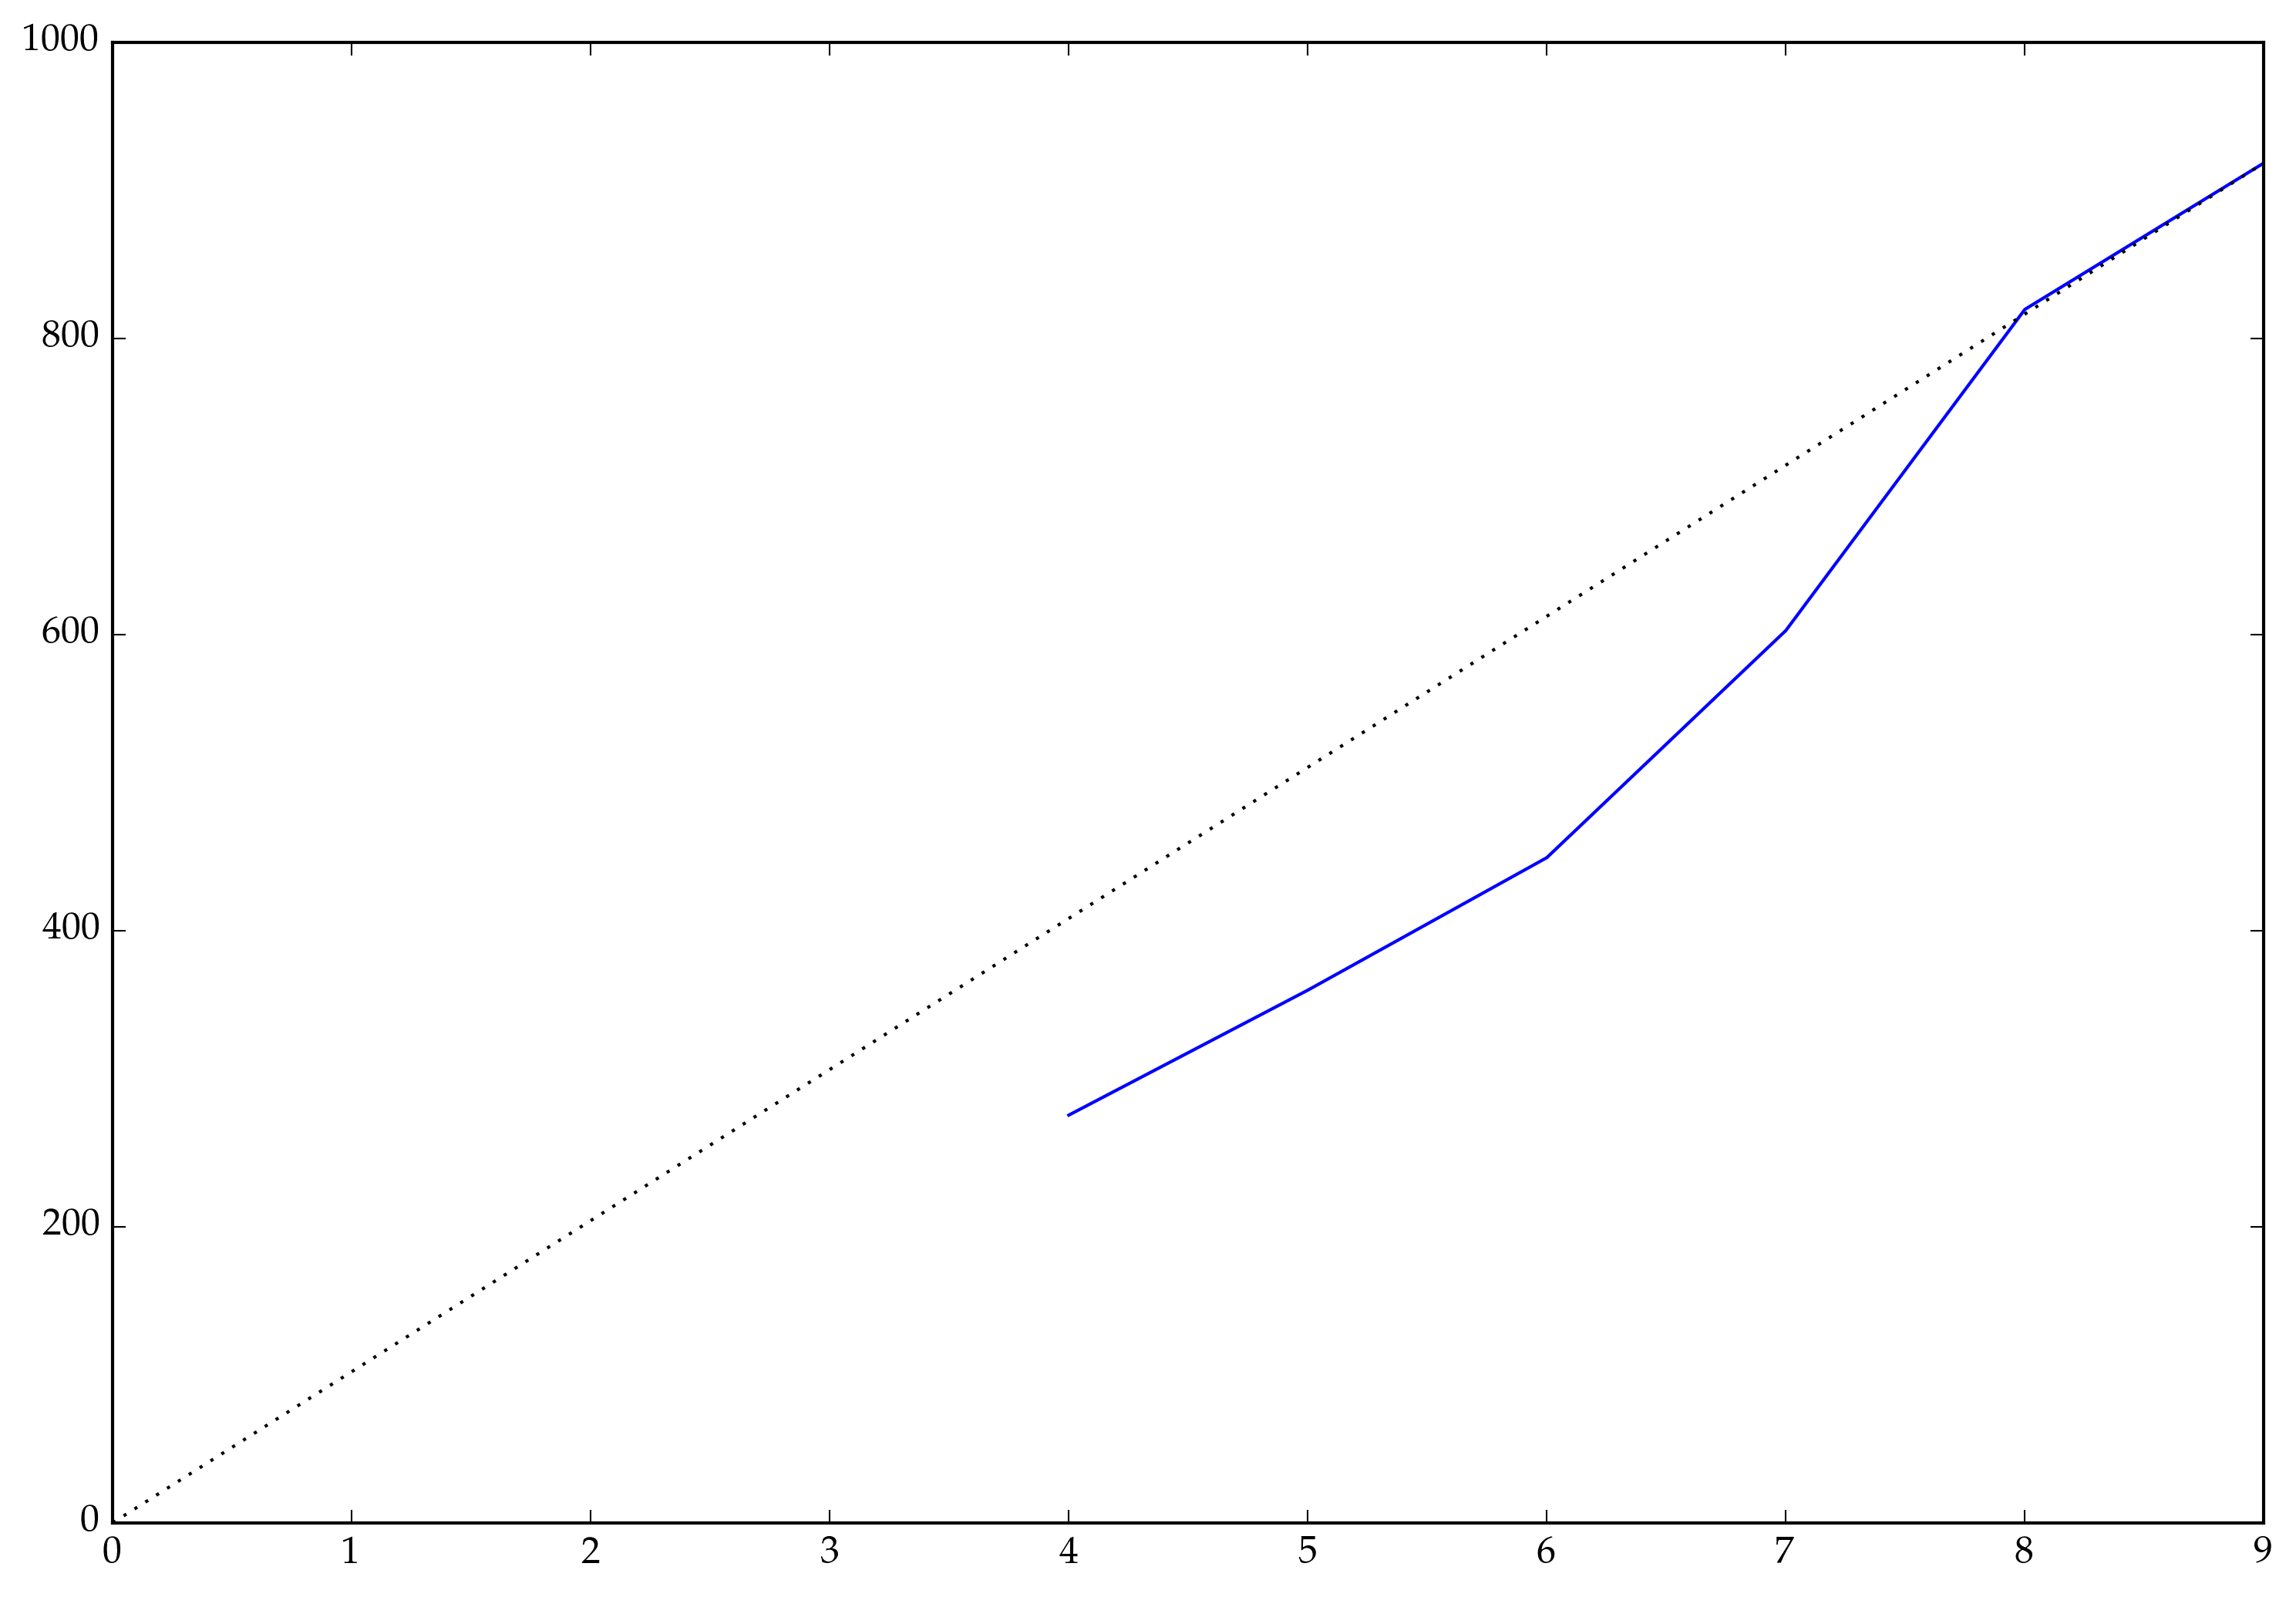

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329411cd0>

In [20]:
days = collect(4:9)
times = [275.296992, 359.682704, 449.193007, 602.574764,819.474179,918.361229]
plt.plot(days, times)
plt.ylim(0,1000)
plt.xlim(0,9)
plt.plot((0,9),(0,918.361229), ":", color="black")

In [115]:
parse(Int, "5")

5